### การแก้สมการอนุพันธ์ด้วย Neural Network
ลิ้งค์อ้างอิง https://arxiv.org/pdf/physics/9705023

ความน่าสนใจอีกหนึ่งอย่างของ Neural Network นอกจากที่จะใช้ใน Machine Learning Tasks ต่าง ๆ แล้วนั้น ก็ยังมีการนำไปใช้แก้สมการอนุพันธ์ (Differential Equation) ได้ด้วย

สมการนี้คือสมการระบบมวลติดสปริงในเรื่องการเคลื่อนที่แบบ SHM (Simple Harmonic Motion)

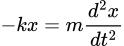

สมมติว่า m และ k เท่ากับ 1  ทำการดึงสปริงออกมา 1 cm แล้วปล่อยจากหยุดนิ่ง

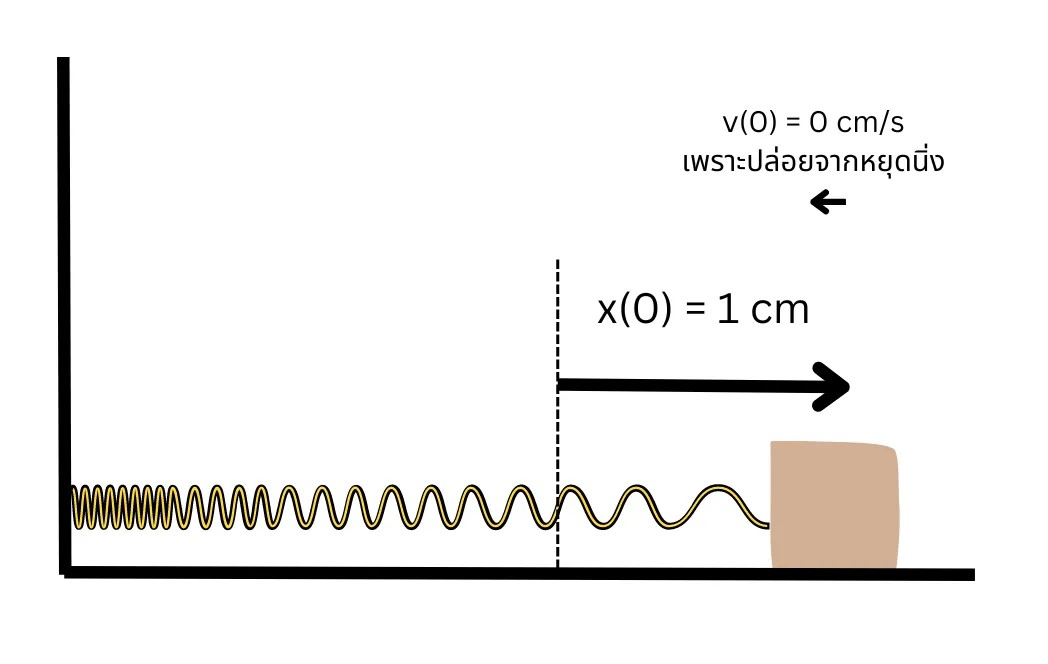

ในกรณีนี้ถ้าเราแก้สมการหา x ซึ่งก็คือการกระจัดออกมาได้ดังภาพ ความหมายของภาพคือมวลติดสปริงจะเด้งกลับไปกลับมา

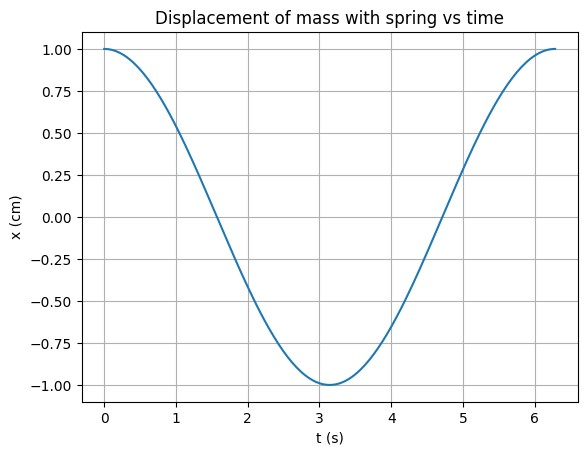



In [ ]:
#import important libs
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

การแก้สมการโดยใช้ Neural Network ใช้แนวคิด ผลรวมเชิงเส้นของหลาย ๆ sigmoid function ผสมกับฟังก์ชัน A และ B จะสามารถแก้ Differential Equation อะไรก็ได้

1_VQKyDeHhmjrStmpZ-3ojeQ.jpg

โดยที่ N ก็คือ output ของ Neural Network

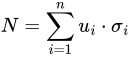

u คือ weight จาก hidden layer ไปหา output layer
สมการข้างต้น N คือการให้ชั้นสุดท้ายมี 1 output แล้วใช้ activation function เป็น linear โครงข่ายจะเป้นดังภาพ

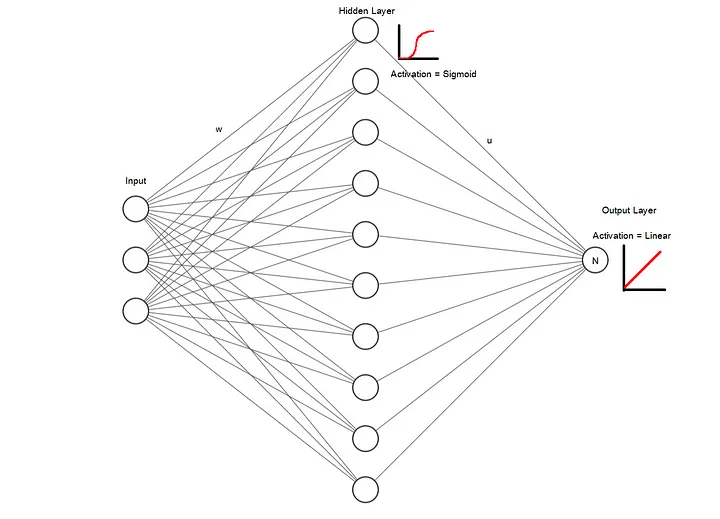

ภาพนี้แสดงถึงโครงข่ายพื้นฐาน ซึ่งสามารถปรับ hyperparameter เช่น จำนวน input layer มีกี่ตัวขึ้นกับสมการที่พยายามจะแก้ ในกรณีของมวลติดปริงมีตัวแปรแค่เวลาดังนั้นจึงใช้ input แค่ 1 แต่หากเป็น PDE ก็จะใช้ input หลายตัว


In [ ]:
model = nn.Sequential(
    nn.Linear(1, 1000),
    nn.Sigmoid(),
    nn.Linear(1000, 1, bias=False)
)

summary(model, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]           2,000
           Sigmoid-2                 [-1, 1000]               0
            Linear-3                    [-1, 1]           1,000
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


โค้ดด้านบนมีจุดสำคัญสองจุด หนึ่งคือชั้น hidden ต้องใช้ activation เป็น sigmoid เท่านั้น และสอง ปรับ bias ที่ชั้นสุดท้ายเป็น False

สิ่งสำคัญคือต้องปรับแก้ loss function ให้เหมาะสมกับสมการต่าง ๆ

แต่ในกรณีนี้ไม่มี train data ในการฟิต จึงต้องใช้สมการสปริง แต่ย้ายข้างสมการ ดังนี้

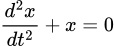

และกำลังสอง ซึ่งการยกกำลังสองนี้มาจากการ dot product ได้ดังนี้

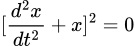

หากสามารถหาค่า x ที่ถูกต้องหรือใกล้เคียงได้ จะทำให้สมการข้างบนเข้าใกล้ 0 ในที่นี้จะเรียกสมการนี้ว่าเป็น loss function

Lagaris กล่าวว่า เมื่อแทน x = A+BN ก็จะแก้สมการอนุพันธ์ได้ แต่ต้องหา A กับ B ให้ได้ก่อน ซึ่งคือฟังก์ชั่นที่ทำให้เงื่อนไขตั้งต้น (Initial Condition) หรือเงื่อนไขขอบเขต (Boundary Condition) เป็นจริง

ยกตัวอย่างเช่น กรณีของสปริง ถ้ากำหนดว่าตอนแรก ยืดสปริงออกมา 1 cm แล้วปล่อยมือให้สปริงดีดกลับ ในขณะปล่อยมือ สปริงเริ่มเคลื่อนที่จากหยุดนิ่ง เงื่อนไขตั้งต้นคือ
การกระจัดตอนแรกมีค่าเป็น 1
และความเร็วเริ่มต้นมีค่าเป็น 0

การกระจัดตอนแรกหรือที่ t = 0 มีค่าเท่ากับ 1

1_Bn5yZK3bnwlFyvv2qgfn4w.jpg

เงื่อนไขที่สองบอกว่าความเร็วที่ t = 0 เป็น 0 ดิฟสมการ x = A + BN 1 ครั้งเพื่อหาสมการความเร็ว จะได้ดังนี้

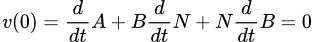

พจน์ที่เพิ่มขึ้นมาจากสูตรหน้าดิฟหลังบวกหลังดิฟหน้า
และ A = 1 และ B = t² ดังนั้น

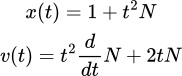

ถ้าแทน t = 0 จะพบว่าสมการแรก x = 1 และสมการที่สอง v = 0 ตรงตามเงื่อนไขตั้งต้น
เมื่อแทนสมการแรกลงใน loss function จะได้ว่า

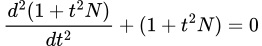

และเมื่อดิฟแล้ว จะได้สมการดังนี้

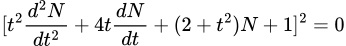

นำมาเป็น code ใส่ใน class CustomLoss

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, inputs):
        super(CustomLoss, self).__init__()
        self.inputs = inputs

    def forward(self, y_pred, y_true):
        N = y_pred
        t = self.inputs
        first_term = (t**2) * torch.autograd.grad(torch.autograd.grad(N, t, torch.ones_like(N), create_graph=True)[0], t, torch.ones_like(N), create_graph=True)[0]
        second_term = 4 * t * torch.autograd.grad(N, t, torch.ones_like(N), create_graph=True)[0]
        third_term = (2.0 + t**2) * N
        res = first_term + second_term + third_term + 1.0
        return torch.mean(torch.square(res), dim=0)

จากนั้น สร้าง data ขึ้นมา ซึ่งไม่ใช่การ train data แต่เป็น interval หรือช่วงตัวเลขที่ต้องการให้ Neural Network พยายามฟิตหาคำตอบ

In [ ]:
t = np.linspace(0, 2 * np.pi, 200).reshape(-1, 1)
t = torch.tensor(t, dtype=torch.float32, requires_grad=True)

ขั้นตอนการฟิต จะรันโดยค่อย ๆ ปรับลด learning rate ข้อสังเกตคือ จะไม่สนใจเรื่องการ overfit แบบ machine learning tasks อื่น ๆ เพราะว่าเน้นให้มี loss ต่ำที่สุดเท่าที่จะเป็นไปได้

In [ ]:
criterion = CustomLoss(t)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Dynamic learning rate
scheduler = StepLR(optimizer, step_size=1500, gamma=0.1)  # Decrease learning rate by a factor of 0.1 every 1500 epochs

In [ ]:
# Training loop
for epoch in range(3000):
    optimizer.zero_grad()
    outputs = model(t)
    loss = criterion(outputs, t)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate
    if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/3000], Loss: {loss.item()}, Learning Rate: {scheduler.get_last_lr()[0]}')

Epoch [1/3000], Loss: 2.256967067718506, Learning Rate: 0.01
Epoch [501/3000], Loss: 0.03901262953877449, Learning Rate: 0.01
Epoch [1001/3000], Loss: 0.024423494935035706, Learning Rate: 0.01
Epoch [1501/3000], Loss: 0.015164761804044247, Learning Rate: 0.001
Epoch [2001/3000], Loss: 0.01441805437207222, Learning Rate: 0.001
Epoch [2501/3000], Loss: 0.013527155853807926, Learning Rate: 0.001


เมื่อรันเสร็จ และใช้ผลลัพธ์โมเดลมาพล็อตกราฟ เทียบกับคำตอบของจริง (Analytical Solution)

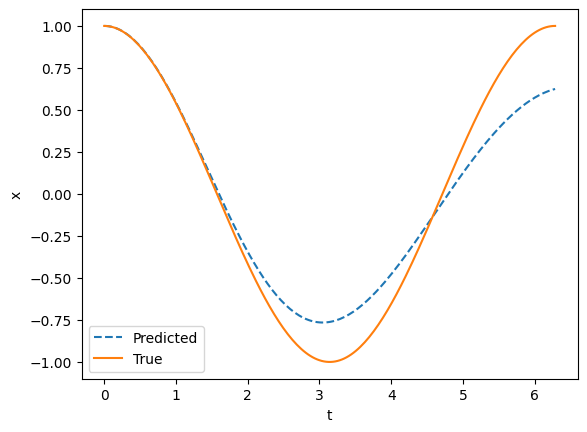

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()
    t_detached = t.detach().numpy()  # Detach t
    t_squared = (t**2).detach().numpy()  # Detach after squaring
    x_pred = 1 + t_squared * model(t).detach().numpy()

x_true = np.cos(t_detached)

# Plot predicted values
plt.plot(t_detached, x_pred, '--', label='Predicted') #numerical solution

# Plot true values
plt.plot(t_detached, x_true, label='True') #analytical solution

plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

จากภาพจะเห็นว่าผลลัพธ์การแก้จาก Neural Network ถือว่าทำได้ดีแม้จะไม่ถูกต้อง 100 เปอร์เซ็น เพราะยังคงมี loss เหลืออยู่ นอกจากนี้ อาจจะปรับปรุงให้ดีขึ้นได้โดยการแบ่งการแก้ปัญหาเป็น interval สั้น ๆ หลาย ๆ ส่วน มาประกอบกันก็ได้

สรุป
1. Neural Network ถือเป็น Algorithm ที่ทรงพลังมาก เพราะความสามารถในการ mapping ซึ่งอาจกล่าวได้ว่าการแก้ด้วย Neural Network มีความคล้ายคลึงกับการทำ Fourier Series ก็ได้ แทนที่จะใช้ sin/cos เป็น basis ซึ่งในกรณีนี้ใช้ sigmoid แทน
2. อย่างไรก็ดี การแก้สมการ DE ด้วย Neural Network แบบพื้น ๆ ไม่เพียงพอแน่นอนและนั่นเป็นเหตุผลที่มีประเภทของ Neural Network อย่าง Lagrangian NN, Hamiltonian NN ซึ่งสองอย่างหลังนี้ มันจะสนใจปริมาณทางฟิสิกส์อย่างอื่นด้วย ซึ่งจะช่วยให้การฟิตคำตอบสมการทำได้ดีขึ้น